In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn

assert(sklearn.__version__ == '1.4.2')

path = os.path.join(os.path.join(os.getcwd(), os.pardir),"data")
print(path)
file = os.path.join(path, "skylab_instagram_datathon_dataset.csv")
data = pd.read_csv(file, delimiter=";")

f:\Documents\Python Scripts\Datathon\datathon\src\..\data


# 1. Data Cleaning & Exploration

The data includes a lot of NaN values. We considered several approaches of dealing with such values and settled on linear interpolation. In that way, the general trends in the data are preserved and we don't throw away any useful data. Additionally, there often occurs the case, that there are NaN values at the beginning and the end of the time series data. In this case, we decided to throw away these datapoints, since it's hard to interpolate the ends without disturbing the general statistics of the data.

In [6]:
# Assuming 'data' is your DataFrame and 'metrics' is a list of columns to interpolate
def clean_dataframe(data, metrics, method: str="linear"):
    data = data.sort_values("period_end_date")
    companies = list(data["business_entity_doing_business_as_name"].unique())
    companies = [name for name in companies if name != "All Brands"]
    new = [None]*len(companies) 
    # Group by the company name and apply interpolation within each group
    for i in range(len(companies)):
        company = companies[i]
        company_idx = (data["business_entity_doing_business_as_name"] == company)
        filtered = data[company_idx]
        filtered[metrics] = filtered[metrics].interpolate(method=method)
        filtered = filtered.dropna(subset=metrics)
        new[i] = filtered

    new_data = pd.concat(new, ignore_index=True)
    return new_data.sort_values("period_end_date")

data["period_end_date"] = pd.to_datetime(data["period_end_date"])

metrics = ["followers", "pictures", "likes", "videos", "comments"]
data = clean_dataframe(data, metrics)

C:\Users\Elias\AppData\Local\Temp\ipykernel_16836\2689017618.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
C:\Users\Elias\AppData\Local\Temp\ipykernel_16836\2689017618.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
C:\Users\Elias\AppData\Local\Temp\ipykernel_16836\2689017618.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

## Data Counts

number companies:  53


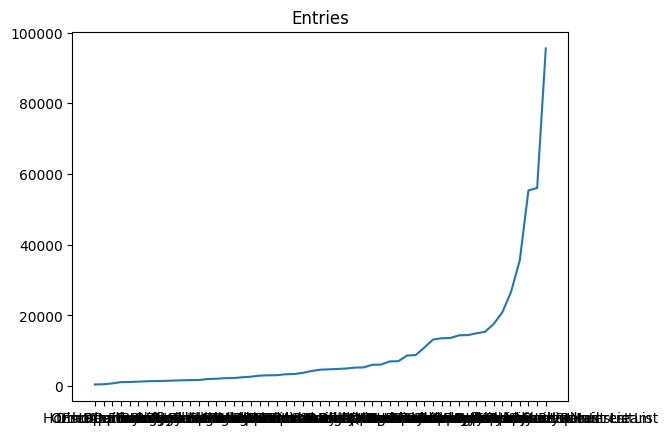

                                     entries   na
Global Luxury Analysts Interest List   26697  NaN
Beauty & Boutique                      35609  NaN
Apparel Retail                         55360  NaN
Luxury & Premium & Mainstream          56016  NaN
US Softlines Analyst Interest List     95490  NaN


In [33]:
import matplotlib.pyplot as plt

def count_entries(data: pd.DataFrame, column: str):
    cats = list(set(list(data["compset"])))
    print("number companies: ", len(cats))

    table = pd.DataFrame(columns=["entries", "na"], index=cats)
    for company in cats:
        data_company = data[data["compset"] == company]
        table.loc[company, "entries"] = len(data_company)
    table = table.sort_values(by=["entries"])
    return table

table = count_entries(data=data, column="compset")
plt.plot(table["entries"])
plt.title("Entries")
plt.show()
print(table[-5:])

## Yearly Means

C:\Users\Elias\AppData\Local\Temp\ipykernel_16836\3090805967.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year


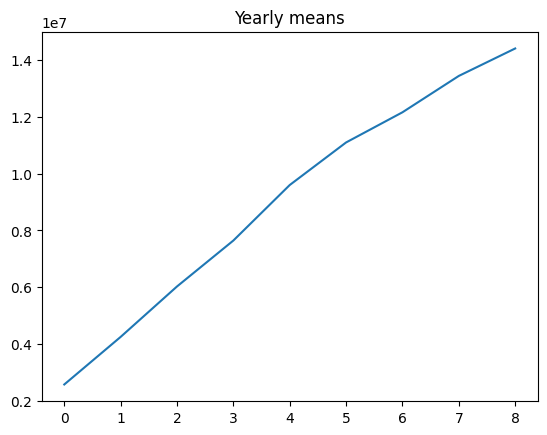

In [34]:
def calculate_yearly_means(df, col, category_column, category_value, period: str="yearly"):
    filtered_df = df[df[category_column] == category_value]
    
    # Convert the index to datetime if it's not already
    if period == "yearly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year
    elif period == "montly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.month

    yearly_means = filtered_df[col].groupby(filtered_df["time"]).mean()
    
    return yearly_means

yearly_means = calculate_yearly_means(data, "followers", "compset", "Soft Luxury", period="yearly")
plt.title("Yearly means")
plt.plot(range(len(yearly_means)), yearly_means)
plt.show()

# 2. Enrichment

To be able to work with more relevant data, we decided to transform our raw data into widely used marketing measures, which better represent the engagement of the  customer with companies social media presence. To this end we employ the following metrics.

These measures collectively offer a comprehensive and exhaustive understanding of social media performance, engagement effectiveness, and content virality for the analyzed companies. This provides a good base for later analysis and the selection of especially relevant and extraordinary features.



In [9]:


#Sort the data by company name and period end date
impute_test = data.sort_values(by=['business_entity_doing_business_as_name', 'period_end_date'])

features = ['followers_delta', 'followers_second_delta',
       'followers_spike', 'average_engagement_per_post',
       'like_to_comment_ratio', 'per_post_aquisition', 'engagement_rate',
       'relative_growth', 'growth_per_post',
       'growth_per_engagement', 'video_by_followers', 'picture_by_followers',
       'picture_virality_index', 'video_virality_index', "virality_index"]

# Group the data by company name
grouped = impute_test.groupby('business_entity_doing_business_as_name')

# For each company, process the data to handle duplicates and compset variations
company_tables = {}
for name, group in grouped:
    # Drop the company name column as it's redundant in individual company dataframes
    group = group.drop(columns='business_entity_doing_business_as_name')
    group.drop_duplicates()
    
    # Group by period_end_date and aggregate
    group = group.groupby('period_end_date').agg({
        'compset': lambda x: list(set(x)),  # Convert compset values to a set to remove duplicates, then to a list
        'followers': 'mean',  # Assuming followers should be averaged
        'pictures': 'sum',  # Summing up the pictures
        'videos': 'sum',    # Summing up the videos
        'comments': 'sum',  # Summing up the comments
        'likes': 'sum'      # Summing up the likes
    }).reset_index()

    # Store the processed DataFrame back to the company_tables dictionary
    company_tables[name] = group


# Iterate over each company in the company_tables
for company, df in company_tables.items():
    # Ensure the data is sorted by date - assuming 'period_end_date' is the weekly identifier
    df = df.sort_values(by='period_end_date')

    # Group by 'period_end_date' to handle data week by week
    weekly_data = df.groupby('period_end_date').agg({
        'likes': 'sum',
        'comments': 'sum',
        'followers': 'mean',  # Assuming 'followers' is stable across the week, we take the mean
        'pictures': 'sum',    # Summing up the number of pictures
        'videos': 'sum'       # Summing up the number of videos
    }).reset_index()

    weekly_data["followers_delta"] = weekly_data["followers"].diff().fillna(0)
    weekly_data["followers_second_delta"] = weekly_data["followers_delta"].diff().fillna(0)

    weekly_data["followers_spike"] = ((weekly_data["followers_delta"] - weekly_data["followers_delta"].median()).abs() > weekly_data["followers_delta"].std()).astype(int)

    # Calculate the average engagement per post for the baseline
    weekly_data['average_engagement_per_post'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate like to comment ratio
    weekly_data['like_to_comment_ratio'] = (weekly_data['likes'] / (weekly_data['comments'] + 0.001))

    # Calculate per post aquisition
    weekly_data['per_post_aquisition'] = weekly_data["followers_delta"] / (weekly_data['likes'] + weekly_data['comments'] + 0.001)

    # Calculate the engagement rate for each week
    weekly_data['engagement_rate'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['followers'] + 0.001)
    weekly_data['picture_engagement'] = (weekly_data['pictures']) / (weekly_data['followers'] + 0.001)
    weekly_data['video_engagement'] = (weekly_data['videos']) / (weekly_data['followers'] + 0.001)

    # Calculate the average likes and comments per post for each week
    weekly_data['average_likes_per_post'] = weekly_data['likes'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['average_comments_per_post'] = weekly_data['comments'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate growth coefficients 
    weekly_data['relative_growth'] = weekly_data['followers_delta']/(weekly_data['followers'] + 0.001)
    weekly_data['growth_per_post'] = (weekly_data['relative_growth'])/(weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['growth_per_engagement'] = (weekly_data['relative_growth'])/(weekly_data['likes'] + weekly_data['comments']+0.001)

    #calculate virality coefficients
    weekly_data['video_by_followers'] = (weekly_data['videos']/(weekly_data['followers'] + 0.001))
    weekly_data['picture_by_followers'] = (weekly_data['pictures']/(weekly_data['followers'] + 0.001))
    weekly_data['picture_virality_index'] = weekly_data['picture_engagement']*weekly_data['relative_growth']
    weekly_data['video_virality_index'] = weekly_data['video_engagement']*weekly_data['relative_growth']
    weekly_data["virality_index"] = weekly_data['picture_virality_index'] + weekly_data['video_virality_index']
    
    df = pd.merge(df, weekly_data[['period_end_date'] + features], on='period_end_date', how='left')
    df["business_entity_doing_business_as_name"] = [company]*len(df)
    # Update the company_tables dictionary with the modified DataFrame
    company_tables[company] = df


  period_end_date                                            compset  \
0      2015-01-10  [Sportswear & Athleisure, Sportswear, US Softl...   
1      2015-01-17  [Sportswear & Athleisure, Sportswear, US Softl...   
2      2015-01-24  [Sportswear & Athleisure, Sportswear, US Softl...   
3      2015-01-31  [Sportswear & Athleisure, Sportswear, US Softl...   
4      2015-02-07  [Sportswear & Athleisure, Sportswear, US Softl...   

    followers  pictures  videos  comments       likes  followers_delta  \
0  25299746.0     465.0     3.0  321669.0  39738612.0              0.0   
1  26143731.0     471.0     9.0  393432.0  43148382.0         843985.0   
2  26851899.0     447.0     9.0  383376.0  40263060.0         708168.0   
3  27483940.0     399.0     9.0  411510.0  36760893.0         632041.0   
4  28077326.0     423.0     6.0  444420.0  36223413.0         593386.0   

   followers_second_delta  followers_spike  ...  engagement_rate  \
0                     0.0                1  ...       

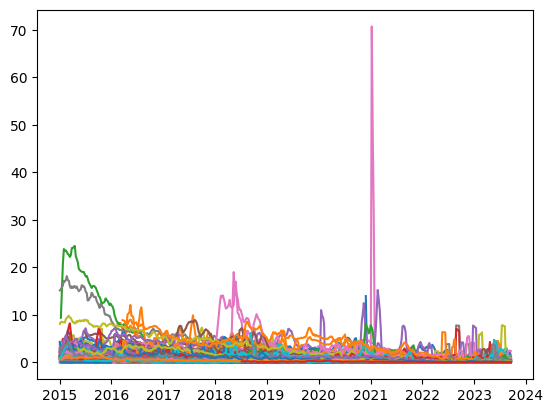

In [10]:
enriched_data = pd.concat(company_tables.values(), ignore_index=True)

company_tables.keys()
enriched_data.head()

plt.figure()
for company in enriched_data["business_entity_doing_business_as_name"].unique():
    company_data = enriched_data[enriched_data["business_entity_doing_business_as_name"] == company]
    plt.plot(company_data["period_end_date"], company_data["engagement_rate"])

In [11]:
def monthly_max_engagement(df, category):
    companies = df['business_entity_doing_business_as_name'].unique()
    ranking = pd.DataFrame(columns=["rank", "n_months"], index=companies, data = np.zeros((len(companies), 2)))
    top_monthly = []

    df["month"] = pd.to_datetime(df["period_end_date"]).dt.month
    df["year"] = pd.to_datetime(df["period_end_date"]).dt.year
    for year in df["year"].unique():
        df_year = df[df["year"] == year]
        for month in df_year["month"].unique():
            df_month = df_year[df_year["month"] == month]

            df_month = df_month.groupby('business_entity_doing_business_as_name').agg({
                        category: 'mean'      # Summing up the number of videos
                        }).reset_index()
            
            df_month = df_month.sort_values(by=[category]).reset_index()
            top_monthly.append(df_month["business_entity_doing_business_as_name"].iloc[-1])
            
            for company_current in df_month["business_entity_doing_business_as_name"].unique():
                a = df_month.index[df_month["business_entity_doing_business_as_name"] == company_current]
                ranking.loc[company_current, "rank"] += a
                ranking.loc[company_current, "n_months"] += 1
    
    ranking["rank"] /= ranking["n_months"]
    return top_monthly, ranking
            
            
top_monthly, total_ranking = monthly_max_engagement(enriched_data, category="engagement_rate")
print(set(top_monthly))

ValueError: setting an array element with a sequence.

In [ ]:
total_ranking.sort_values(by=["rank"])

,rank,n_months
Boca,5.060000,50.0
Helix,20.530864,81.0
Powerade,24.858696,92.0
Bobstore,29.984127,63.0
Leesa,36.952941,85.0
...,...,...
Funko,643.428571,63.0
SHEIN,649.701493,67.0
Pop Mart,679.181818,11.0
Fashion Nova,683.944444,36.0


In [17]:
coca_holding = ["SPRITE", "Costa Coffee", "Schweppes", "Coca-Cola", "Powerade"]
for company in coca_holding:
    print(total_ranking.loc[company, "rank"])

99.828125
406.3880597014925
238.52941176470588
113.94565217391305
24.858695652173914
92.73333333333333


# 3. Modelling


In [12]:
def average_table(df, category_column, interesting_period, features, period: str="yearly"):
    cats = df[category_column].unique()
    table = pd.DataFrame(columns=features, index=cats)
    
    if period == "yearly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.year
    elif period == "monthly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.month

    df = df[df["time"] == interesting_period]

    for cat in cats:
        df_cat = df[df[category_column] == cat]
        for col in features:
            table.loc[cat, col] = np.nanmean(df_cat[col])
     
    return table.dropna() #?? 

table = average_table(enriched_data, "business_entity_doing_business_as_name", 2023, features)
print(table.head())

                  followers_delta followers_second_delta followers_spike  \
24S                         559.0              18.189189        0.027027   
3.1 Phillip Lim        968.513514               83.72973        0.027027   
3CE                    -950.72973              23.918919             0.0   
A. Lange & Soehne     1306.756757              12.594595             0.0   
ANIMALE                718.594595              33.189189        0.027027   

                  average_engagement_per_post like_to_comment_ratio  \
24S                                876.513464              63.25483   
3.1 Phillip Lim                    235.597816             43.125704   
3CE                                940.604495            312.048218   
A. Lange & Soehne                 5100.448949            164.050237   
ANIMALE                           1337.547676             24.879431   

                  per_post_aquisition engagement_rate relative_growth  \
24S                          0.010389      

We need to first scale our dataframe to ensure that no feature weighs too much compared to others and skew the centroids of our kmeans

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(table), columns = table.columns, index = table.index )

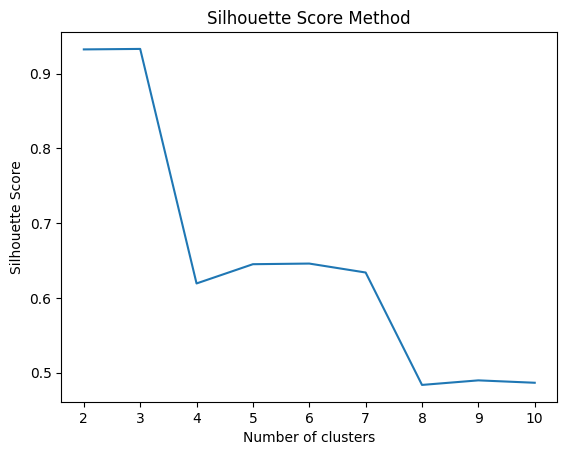

In [14]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def kmeans_silhouette_scores(df):
    silhouette_scores = []

    # Example using the same dataset as above
    for i in range(2, 11):  # Silhouette score cannot be computed with only one cluster
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores

relevant_features = ['followers_delta', 'followers_second_delta', 'followers_spike', 'average_engagement_per_post',
 'like_to_comment_ratio', 'engagement_rate', 'relative_growth', 'growth_per_post', 
 'growth_per_engagement', 'virality_index']

rel_table = table[relevant_features]
rel_table = rel_table.div(rel_table.max())
silhouette_scores = kmeans_silhouette_scores(rel_table)
# Plotting the results
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

## Clustering Parameters

From our first subset of variables, N seems like a useful amount of clusters. 
In the silhouette score plot, one can see how well different amounts of clusters fit ou
r data. N seems like a good fit since it looks like a local minimum after a steep drop. This minimizes the mean, while keeping the variance modest.

In [15]:
n_clusters = 4

In [16]:
def apply_kmeans_clustering(df, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters,random_state=1)
    kmeans.fit(df)
    return df, kmeans
""" 
def get_outliers(df, model):
    df["dist"] = np.min(model.transform(df), axis=1)
    df = df.sort_values(by=["dist"])
    df["label"] = model.labels_
    return df[-5:] """

def get_outliers(df, model, k):
    centroid_distances = model.transform(df)

    labels = model.predict(df)
    min_distances = np.min(model.transform(df), axis=1)
    critical_idx = np.zeros(min_distances.shape)

    df["dist"] = min_distances
    for i in range(model.n_clusters):
        cluster_idx = (labels == i)    
        median_dist = np.median(centroid_distances[cluster_idx, i])
        std_dist = np.std(centroid_distances[cluster_idx, i])
        critical_idx[cluster_idx] = np.abs(min_distances[cluster_idx] - median_dist) > k*std_dist

    index = pd.array(critical_idx,dtype="boolean")
    return index

rel_table, model = apply_kmeans_clustering(rel_table, num_clusters=n_clusters)
centers = pd.DataFrame(data=model.cluster_centers_, columns=rel_table.columns)

is_outlier = get_outliers(rel_table, model, k=2)
outliers = rel_table[is_outlier]
print("Imortant: " , outliers.index)
print("outlier percentage:", len(outliers)/len(rel_table))
for _, outlier in outliers.iterrows():
    print("profile:", outlier)

Index(['Antarctica', 'Balenciaga', 'Boca', 'Bulgari', 'Calvin Klein', 'Celine',
       'Chaumet', 'Dior', 'Fiever', 'Finding Unicorn', 'Flywheel Sports',
       'Foot Action', 'Hylete', 'KFC', 'Kenzo Beauty', 'Lilys Kitchen',
       'Louis Vuitton', 'Meow Mix', 'Montejo', 'Pure Farmland', 'Rolife',
       'SK-II', 'Sleep Number', 'Sofina', 'Starwars', 'Superdown', 'Tecate',
       'Temu', 'The Meatless Farm', 'The Very Good Butchers', 'Tiffany & Co.',
       'Tobi', 'Trask', 'Uniqlo', 'Wolaco'],
      dtype='object')
outlier percentage: 0.04971590909090909
profile: followers_delta                0.000094
followers_second_delta         -0.00308
followers_spike                 0.27027
average_engagement_per_post         0.0
like_to_comment_ratio               0.0
engagement_rate                     0.0
relative_growth                0.019587
growth_per_post                     1.0
growth_per_engagement               1.0
virality_index                      0.0
dist                        

## Surrogate Model

To explore the different classes of companies that we have extracted, we train a surrogate decision tree model. In this way, we can express the boundaries between clusters as decision trees. To this end we emply the sklearn implementation of a decision tree classifier.

In [17]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

Surrogate Accuracy: 96.31%


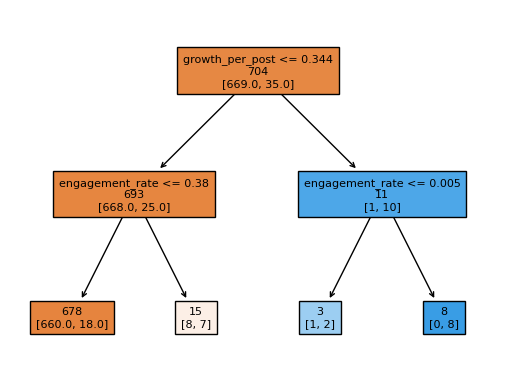

In [18]:
def surrogate(df, features, target):
    classifier = DecisionTreeClassifier(random_state=0, max_depth=2,monotonic_cst=np.repeat(1,len(features)))
    d_train = df[features]
    classifier.fit(d_train, target)

    tree.plot_tree(classifier, fontsize=8, feature_names=features, label="none", impurity=False, filled=True)
    plt.savefig("hjoimichal.png")
    print(f"Surrogate Accuracy: {round(classifier.score(d_train, target),4)*100}%")

surrogate(rel_table, relevant_features, is_outlier)
    

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

_, model = apply_kmeans_clustering(table, num_clusters=n_clusters)

y = label_binarize(model.labels_, classes = [0,1,2,3])
clf=RandomForestClassifier()
clf.fit(table, y)

RandomForestClassifier()

In [31]:
import shap

explainer = shap.TreeExplainer(clf)

shap_values = explainer(table).values

print(type(shap_values))


print(np.array(shap_values).shape)

for i in range(1, 4):
    class_index = i
    outliers.reset_index(drop=True, inplace=True)
    table.reset_index(drop=True, inplace=True) 
    labels = model.predict(table.iloc[outliers.index])
    cluster_idx = (labels == class_index)
    outliers.reset_index(drop=True, inplace=True)
    idx = outliers[cluster_idx].index

    shap_values_class = shap_values[idx, class_index,:]
    print(shap_values_class.shape)

    shap.summary_plot(shap_values_class, table.iloc[idx,:7])
print(list)

<class 'numpy.ndarray'>
(704, 15, 8)
(0, 8)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix. Perhaps the extra column in the shap_values matrix is the constant offset? Of so just pass shap_values[:,:-1].

                             followers_delta  followers_second_delta  \
followers_delta                     1.000000                0.272733   
followers_second_delta              0.272733                1.000000   
followers_spike                     0.268297               -0.036392   
average_engagement_per_post         0.507736                0.074210   
like_to_comment_ratio              -0.033347               -0.045818   
per_post_aquisition                 0.805551                0.218730   
engagement_rate                     0.463143               -0.001569   
relative_growth                     0.961866                0.222555   
growth_per_post                     0.646634                0.106132   
growth_per_engagement               0.772247                0.166907   
video_by_followers                 -0.373624               -0.039845   
picture_by_followers               -0.335509               -0.058333   
picture_virality_index              0.880948                0.25

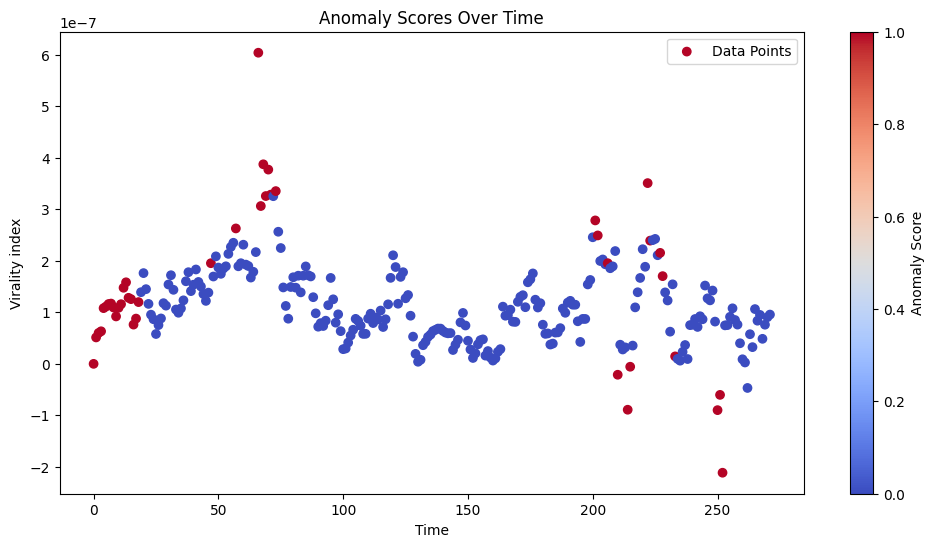

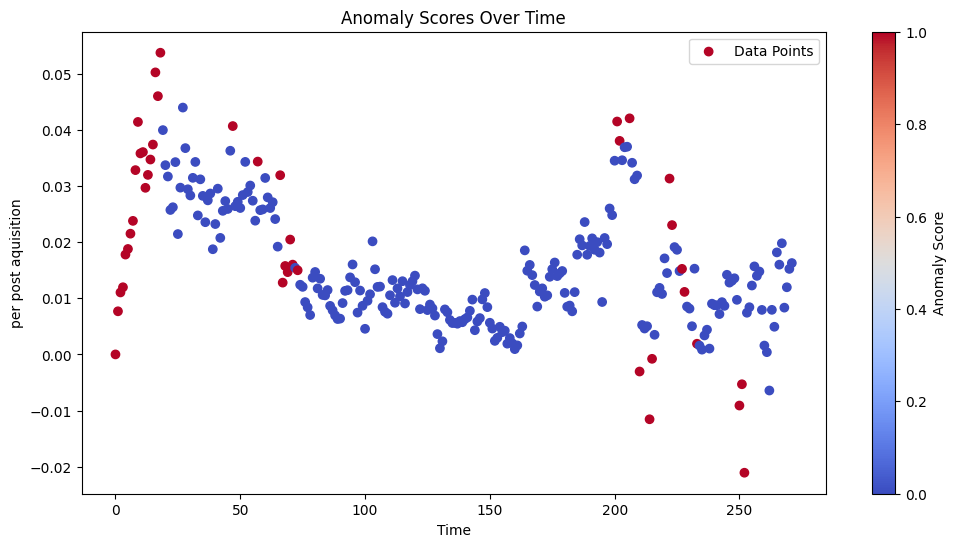

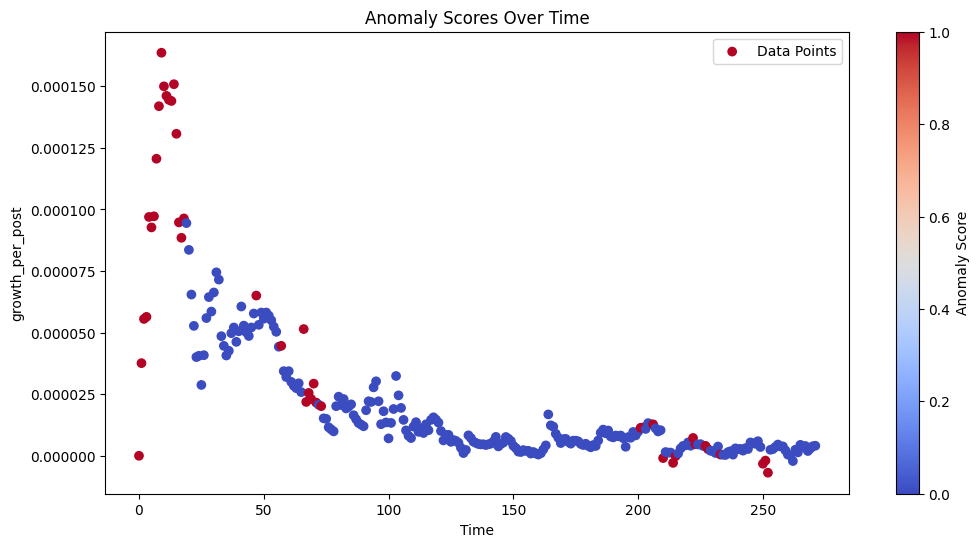

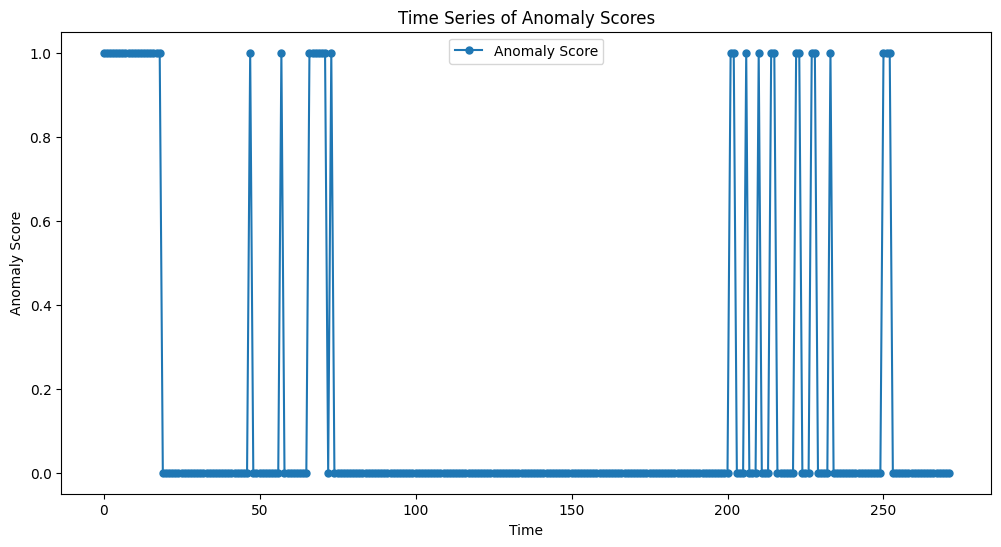

In [35]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators = 100, contamination = 'auto')
model.fit(df[features])


df['anomaly_score'] = model.predict(df[features])
df['anomaly_score'] = df['anomaly_score'].map({1: 0, -1: 1})

correlation_matrix = df[features].corr()
print(correlation_matrix)


plt.figure(figsize=(12, 6))
plt.scatter(df.index, df["virality_index"], c=df['anomaly_score'], cmap='coolwarm', label='Data Points')
plt.colorbar(label='Anomaly Score')
plt.title('Anomaly Scores Over Time')
plt.xlabel('Time')
plt.ylabel('Virality index')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df["per_post_aquisition"], c=df['anomaly_score'], cmap='coolwarm', label='Data Points')
plt.colorbar(label='Anomaly Score')
plt.title('Anomaly Scores Over Time')
plt.xlabel('Time')
plt.ylabel('per post aquisition')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df["growth_per_post"], c=df['anomaly_score'], cmap='coolwarm', label='Data Points')
plt.colorbar(label='Anomaly Score')
plt.title('Anomaly Scores Over Time')
plt.xlabel('Time')
plt.ylabel('growth_per_post')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['anomaly_score'], marker='o', linestyle='-', markersize=5, label='Anomaly Score')
plt.title('Time Series of Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

We use an IsolationForest to check if the metrics we obtained to characterize our anomalies in the dataset are in fact meaningful and useful. We use this method for its ease of computation in big datasets, for it not needing normalization and it's robustness to data contamination, making it a great choice to plot our anomaly metrics over time. We also don't try to optimize the parameters as this model serves as a sanity check. We can immediately see that the model struggles to fit the anomalies at the beginning of the time series, but fits them well at the end. This is due to the model getting more contextual data with time and the metrics getting better. We see that our metrics catch a lot of the anomaly dynamics.